# Lab 1: Convolutional Neural Networks

This notebook contains the key concepts and steps to implementing a Convolutional Neural Network.
Implementing the tasks below should give you an idea of how this method for image classification works.

## STEP 0: Get an idea about the dataset

### Nothing to be done here

**CIFAR** - Canadian Institute For Advanced Research.

CIFAR-10 and CIFAR-100 datasets were developed by the researchers at the CIFAR institute.

This dataset has 60.000 color (depth 3) images 32x32 (WxH) of objects from 10 classes:
- 0: airplane
- 1: automobile
- 2: bird
- 3: cat
- 4: deer
- 5: dog
- 6: frog
- 7: horse
- 8: ship
- 9: truck.

These are really small images and suitable for the purposes of this lab: we want to learn 
how to implement a convolutional neural network, without painfully waiting for the training to end.

The images are indeed very small compared to modern photographs. It can be challenging to see what exactly is represented in some of them. This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.

On this dataset it is relatively straightforward to achieve 80% classification accuracy.
Using deep CNNs a top performance above 90% accuracy is achieved.



## STEP 1: Load the data
### 1.1. Load the dataset
### 1.2. Reshape the inputs

> Reshape the dataset inputs X_train and X_test to fit the model. Here 50000 is the number of samples, 32 is the width/height, 3-for the channels of color - Keras requires this 3rd dimension.

### 1.3. One-hot encode the target column
> E.g. if the input image contains a plane, the 3rd element of the target column is going to be 1 and the rest of the elements 0.




In [1]:
import torch
import typing as t
import pathlib as pb
import matplotlib.pyplot as plt


ROOT_PATH: pb.Path = pb.Path('.')
DATASETS_PATH: pb.Path = ROOT_PATH / 'datasets'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Files already downloaded and verified


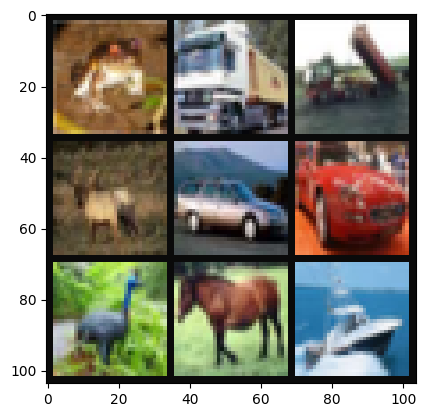

In [2]:
import torch
import torch.utils
import torch.utils.data
import torchvision
import torchvision.utils
import torchvision.datasets as datasets

from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.utils import make_grid
from torchvision.transforms import Compose, PILToTensor


def load_data(dataset: t.Literal['mnist', 'cifar10'] = 'cifar10') -> t.Tuple[Tensor, Tensor, Tensor, Tensor]:
    _dataset = datasets.MNIST if dataset == 'mnist' else datasets.CIFAR10
    # Download/Load data from internet/disk
    path_to_data = str(pb.Path('.', 'datasets'))
    train = _dataset(root=path_to_data, transform=PILToTensor(), train=True, download=True)
    test = _dataset(root=path_to_data, transform=PILToTensor(), train=False, download=True)

    # Iterate and collate
    X_train, y_train = torch.utils.data.default_collate([x for x in train])
    X_test, y_test = torch.utils.data.default_collate([x for x in test])
    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_data()
plt.imshow(make_grid(X_train[:9], nrow=3, pad_value=10).permute(1, 2, 0))

## STEP 2: Prepare the data
### 2.1. Convert the pixels 
> From integers to floats.

### 2.2. Normalize the pixel values 
> From [0, 255] to [0.0, 1.0]. This is optional but in general using smaller values tends to give better results. Try also without this pre-processing and look at the loss.

In [3]:
def prepare_data(train: Tensor, test: Tensor) -> t.Tuple[Tensor, Tensor]:
    train = train.type(torch.float32)
    test = test.type(torch.float32)

    train_norm = train / 255.
    test_norm = test / 255.

    return train_norm, test_norm

X_train, X_test = prepare_data(X_train, X_test)

## STEP 3: Build the model

### 3.1. Create the model:
> Sequential() is the easiest way to build a model in Keras. This allows you to build a model layer by layer. There is also Model() - class. Not in the scope of this lab.
         
         
### 3.2. Add layers.
> We can add the layers directly in the constructor (as a list) or later, using add().
  - **L1**: a **convolutional layer** with **32 nodes**. Kernel size is 3 => **3x3 filter** matrix. Note that on the first conv layer we need to specify the input shape. The best parameters for this layer: **padding='same'**, **activation='relu'**.
  - **L2**: In the second (also **conv**) layer we have **32 nodes** and the same parameters as above. 
  - **L3**: **Max Pooling** with **2x2 size** for the filter - can try without it and see what happens with the train time/loss.
  - **L4**: Add a **dropout** layer - commonly used to prevent overfitting. Drop **1/4** of the neurons.
  - **L5**: Add a **convolutional** layer with **64 neurons**, **kernel size 3**, **padding same** and **activation relu**.
  - **L6**: Add a **convolutional** layer with **64 neurons**, **kernel size 3** and **activation relu**.
  - **L7**: Add a **Max Pooling** layer with **filter size 2x2**.
  - **L8**: Add a **Dropout** layer, with **1/4** of the neurons dropped.
  - **L9**: Add a **Flatten** layer - the flatten layer serves as a connection b/w the conv and dense layers. Flatten = squeeze into 1D the activation maps and put them together. (Aka convert matrix to single array).
  - **L10**: Add a **Dense** layer with **512** nodes, **relu** activation.
  - **L11**: Add a **Dropout** layer, where **half** of the neurons are **dropped**.
  - **L12**: Add a **Dense** layer. In this case the Dense layer is used for the output layer: **10 nodes**, for each possible outcome (0 - 10). The activation is **softmax** - makes the outputs to sum up to 1 => interpret them as probabilities.  The model is going to make its prediction based on which option has the highest probability.


In [4]:
import torch.nn as nn
from torch.nn import Conv2d, Linear, Sequential, ReLU, MaxPool2d, Dropout, Flatten


def build_model():
    model = Sequential()

    model.append(Conv2d(3, 32, (3, 3), padding='same'))
    model.append(ReLU())
    model.append(Conv2d(32, 32, (3, 3)))
    model.append(ReLU())

    model.append(MaxPool2d((2, 2)))
    model.append(Dropout(.25))

    model.append(Conv2d(32, 64, (3, 3), padding='same'))
    model.append(ReLU())
    model.append(Conv2d(64, 64, (3, 3)))
    model.append(ReLU())

    model.append(MaxPool2d((2, 2)))
    model.append(Dropout(.25))

    model.append(Flatten())

    model.append(Linear(2304, 512))
    model.append(ReLU())
    model.append(Dropout(.5))
    model.append(Linear(512, 10))

    # Don't use softmax as cross_entropy expects logits
    # model.append(Softmax(dim=-1))
    return model


model = build_model().to(device)
model

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.25, inplace=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): Dropout(p=0.25, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=2304, out_features=512, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=512, out_features=10, bias=True)
)

## STEP 4: Compile the model
> Here we are going to need and optimizer, a loss function and a metric.
  - **Optimizer** 
     - controls the learning rate. Here: **Adam** - a good optimizer for many cases.
       Adam adjusts the learning rate throughout training.
       Learning rate = how fast the optimal weights for the model are computed.
       The LR value involves a trade-off b/w speed (larger lr) and accuracy(smaller lr).
     - Other optimizers: https://keras.io/optimizers/  
  - **Loss**
     - **categorical_crossentropy** - a common choice for classification ( > 2 classes). The lower the score, the better.
     - Other losses: https://keras.io/losses/ 
  - **Metric**
     - **accuracy** - not the best choice but it is ok to make things easier.

In [5]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from collections import namedtuple

# Loss and optimizer
loss_fn = CrossEntropyLoss()
optim = Adam(model.parameters())
metric = accuracy_score

# Customize training loop
epochs = 100
batch_size = 64
steps_per_epoch = 64
History = namedtuple('History', ['history'])

In [6]:
def fit(model, X_train, y_train, epochs, batch_size, steps_per_epoch, seed) -> History:
    # Split into training & validation
    gen = torch.Generator().manual_seed(seed)
    train_dataset = TensorDataset(X_train, y_train)
    train_dataset, \
    valid_dataset = random_split(train_dataset, [0.8, 0.2], gen)

    # Customize data loading process
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, generator=gen)
    valid_loader = DataLoader(valid_dataset, batch_size, shuffle=True, generator=gen)

    # Track evolution
    history =  History({
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    })

    # Train and Validate
    for e in range(epochs):
        ### Train one epoch ###
        print('Epoch %u/%u' % (e + 1, epochs))
        train_iter = iter(train_loader)
        accuracy_all = torch.empty((steps_per_epoch,))
        loss_all = torch.empty((steps_per_epoch,))
        model.train(True)

        ### Go over all steps in the epoch ###
        for s in range(steps_per_epoch):
            # Fetch data
            X_t_batch, y_t_batch = next(train_iter)

            # Move data to GPU
            X_t_batch, y_t_batch = X_t_batch.to(device), y_t_batch.to(device)

            # Predict
            y_t_pred: Tensor = model(X_t_batch)
            y_t_label: Tensor = y_t_pred.argmax(dim=-1)

            # Compute metrics
            loss: Tensor = loss_fn(y_t_pred, y_t_batch)
            accuracy = metric(y_t_batch.cpu(), y_t_label.detach().cpu())
            print('%s/%u - loss: %f - accuracy %f' % (str(s + 1).rjust(2), steps_per_epoch, loss, accuracy), end='\n' if s != steps_per_epoch - 1 else '')

            # Apply chain rule
            optim.zero_grad()
            loss.backward()
            optim.step()

            # Track results
            loss_all[s] = loss.detach().cpu().item()
            accuracy_all[s] = accuracy
        history.history['accuracy'].append(accuracy_all.mean())
        history.history['loss'].append(loss_all.mean())

        ### Validate after epoch ###
        model.train(False)
        y_v_prob_all = torch.empty((len(valid_loader.dataset), 10), dtype=torch.float32)
        y_v_pred_all = torch.empty((len(valid_loader.dataset),), dtype=torch.int64)
        y_v_true_all = torch.empty((len(valid_loader.dataset),), dtype=torch.int64)

        ### Go over all steps in the validation set ###
        for i, (X_v_batch, y_v_batch) in enumerate(valid_loader):
            # Fetch data & send to GPU
            X_v_batch, y_v_batch = X_v_batch.to(device), y_v_batch.to(device)

            # Infer
            with torch.no_grad():
                y_v_pred: Tensor = model(X_v_batch).cpu()
                y_v_prob_all[i * batch_size:i * batch_size + y_v_batch.numel(), ...] = y_v_pred
                y_v_true_all[i * batch_size:i * batch_size + y_v_batch.numel()] = y_v_batch.cpu()
                y_v_pred_all[i * batch_size:i * batch_size + y_v_batch.numel()] = y_v_pred.argmax(dim=-1)

        # Compute metrics
        loss = loss_fn(y_v_prob_all, y_v_true_all)
        accuracy = metric(y_v_true_all, y_v_pred_all)

        # Track results
        history.history['val_loss'].append(loss.item())
        history.history['val_accuracy'].append(accuracy)
        print(' - val_loss %f - val_accuracy %f' % (loss, accuracy))
    return history

In [7]:
history = fit(
    model=model,
    X_train=X_train,
    y_train=y_train,
    epochs=100,
    batch_size=64,
    steps_per_epoch=64,
    seed=42,
)

Epoch 1/100
 1/64 - loss: 2.304764 - accuracy 0.109375
 2/64 - loss: 2.298811 - accuracy 0.125000
 3/64 - loss: 2.307877 - accuracy 0.125000
 4/64 - loss: 2.312667 - accuracy 0.031250
 5/64 - loss: 2.317763 - accuracy 0.125000
 6/64 - loss: 2.293520 - accuracy 0.109375
 7/64 - loss: 2.304796 - accuracy 0.140625
 8/64 - loss: 2.308469 - accuracy 0.093750
 9/64 - loss: 2.304540 - accuracy 0.125000
10/64 - loss: 2.288378 - accuracy 0.187500
11/64 - loss: 2.301215 - accuracy 0.171875
12/64 - loss: 2.280898 - accuracy 0.109375
13/64 - loss: 2.297017 - accuracy 0.093750
14/64 - loss: 2.253808 - accuracy 0.187500
15/64 - loss: 2.339110 - accuracy 0.062500
16/64 - loss: 2.282551 - accuracy 0.140625
17/64 - loss: 2.289678 - accuracy 0.046875
18/64 - loss: 2.268398 - accuracy 0.281250
19/64 - loss: 2.279651 - accuracy 0.125000
20/64 - loss: 2.240710 - accuracy 0.171875
21/64 - loss: 2.275811 - accuracy 0.140625
22/64 - loss: 2.210875 - accuracy 0.140625
23/64 - loss: 2.237022 - accuracy 0.078125

## STEP 6: Save the model

From this model we are interested in the weights. Thus, in order to use the model later, we need to save the weights learned at training time.

In [8]:
torch.save(model.state_dict(), 'cifar_cnn.pt')

## STEP 7: Make predictions
> Use the **predict()** function to see the actual predictions that our model has made for the test data.The predict() function gives an array with 10 numbers - the probaility that th input is 0-9. The array index with the highest value is the prediction made by the model.

> Additionally: re-load the trained model. Essentially what we have to do here is to rebuild the model and load in the saved weights.

In [9]:
import numpy as np


@torch.no_grad()
def predict(model, x_test, batch_size=64):
    return torch.cat([model(x.to(device)).cpu() for (x,) in DataLoader(TensorDataset(x_test), batch_size=batch_size)])


@torch.no_grad()
def load_test_model():
    # TODO 7.1. (re)build the model
    test_model = build_model().eval().to(device)

    # TODO 7.2. load the model's saved weights.
    test_model.load_state_dict(torch.load('cifar_cnn.pt'))

    # TODO 7.3. Predict the class of the first 10 images in the test set
    predictions = predict(model, X_test, 64)

    # 7.4. Print the predictions done by the model ([7, 2, 1, 0, 4])
    print("Predictions: \n", np.argmax(predictions[:20, ...], axis=1))

    # 7.5. Check our predictions against the ground truths ([7, 2, 1, 0, 4])
    print("Ground truth: \n", y_test[:20])


load_test_model()

Predictions: 
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 4, 9, 5, 7, 9, 6, 5, 3, 8, 6])
Ground truth: 
 tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])


## STEP 8: Learning Curves

Plot the learning curves to get an idea about how the model learns, overfitting, etc.

> 73.020


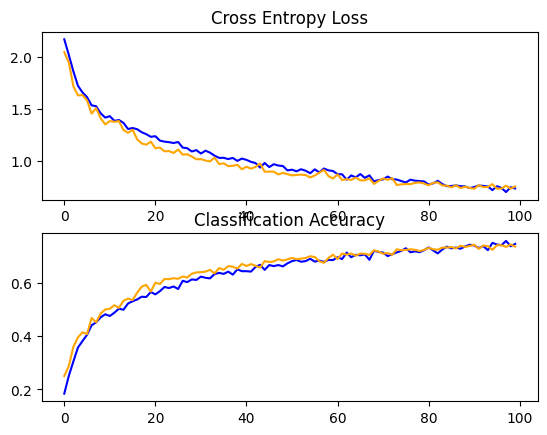

In [10]:
import sys

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')


plt.show()

# evaluate model
with torch.no_grad():
    acc = metric(y_test, predict(model, X_test, 64).argmax(dim=-1))

print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history)

## BONUS

With the knowledge achieved through this lab, build a simplified CNN which is able to classify the digits in the MNIST dataset. The network does not need to have more than 2 convolutional layers in order for the performance to be satisfactory in terms of accuracy.

Note that the MNIST dataset is lighter than CIFAR as the images are grayscale (only one color channel).

image shape:  torch.Size([1, 28, 28])


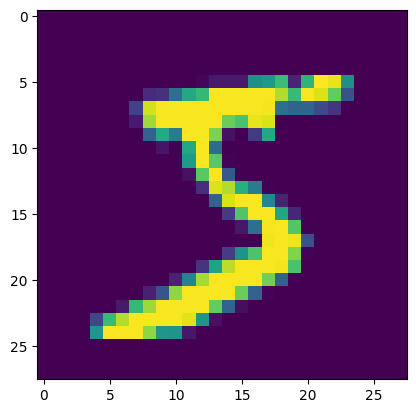

In [11]:
X_train, y_train, X_test, y_test = load_data('mnist')

plt.imshow(X_train[0].squeeze(0))

print('image shape: ', X_train[0].shape)

In [12]:
######################
# B2. Prepare the data
######################
# TODO B2.1. Normalize the pixel values from [0, 255] to [-0.5, 0.5].
X_train = (X_train - 127.5) / 255.
X_test = (X_test - 127.5) / 255.

# TODO B2.2. Reshape the dataset inputs X_train and X_test to fit the model
# train: (60000, 28, 28, 1), test: (10000, 28, 28, 1)
X_train = X_train.permute(0, 1, 2, 3)
X_test = X_test.permute(0, 1, 2, 3)

# TODO B2.3. One-hot encode the target column (Not needed)
print("y_train[0] number: ", y_train[0].item())

y_train[0] number:  5


In [22]:
#####################
# B3. Build the model
#####################
def build_mnist_model():
    # TODO B3.1. Create model
    return Sequential(
        # TODO B3.2. Add conv layer - 64 nodes, 3x3, relu
        Conv2d(1, 64, (3, 3)),
        ReLU(),
        # TODO B3.3. Add conv layer - 32 nodes, 3x3, relu
        Conv2d(64, 32, (3, 3)),
        ReLU(),
        # TODO B3.4. Add max pooling layer - 2x2 pool size
        MaxPool2d((2, 2)),
        # TODO B3.5. Add a dropout layer - 0.5
        Dropout(.5),
        # TODO B3.6. Add flatten layer
        Flatten(),
        # TODO B3.7. Add dense layer - 10 nodes, NO softmax
        Linear(32 * 12 * 12, 10)
    )

model = build_mnist_model().to(device)

In [23]:
########################
# B4. Compile the model
#######################

# TODO B4. Optimizer: adam, Loss: categorical_crossentropy, Metric: accuracy.
optim = Adam(model.parameters())
loss_fn = CrossEntropyLoss()
metric = accuracy_score
model = model.to(device)

In [24]:
# TODO B5. Use the fit() function with the parameters:
#   - training data: train_X (images)
#   - target data: train_y (labels)
#   - validation data: X_test, y_test
#   - number of epochs: 3
history = fit(
    model=model,
    X_train=X_train,
    y_train=y_train,
    epochs=3,
    batch_size=64,
    steps_per_epoch=64,
    seed=42,
)

Epoch 1/3
 1/64 - loss: 2.297704 - accuracy 0.062500
 2/64 - loss: 2.311137 - accuracy 0.156250
 3/64 - loss: 2.273908 - accuracy 0.156250
 4/64 - loss: 2.258445 - accuracy 0.156250
 5/64 - loss: 2.192289 - accuracy 0.296875
 6/64 - loss: 2.200309 - accuracy 0.375000
 7/64 - loss: 2.118612 - accuracy 0.484375
 8/64 - loss: 1.985085 - accuracy 0.593750
 9/64 - loss: 1.969175 - accuracy 0.515625
10/64 - loss: 1.970561 - accuracy 0.515625
11/64 - loss: 1.839143 - accuracy 0.562500
12/64 - loss: 1.744284 - accuracy 0.578125
13/64 - loss: 1.683878 - accuracy 0.468750
14/64 - loss: 1.454256 - accuracy 0.718750
15/64 - loss: 1.407089 - accuracy 0.687500
16/64 - loss: 1.187370 - accuracy 0.781250
17/64 - loss: 1.212933 - accuracy 0.625000
18/64 - loss: 1.019191 - accuracy 0.781250
19/64 - loss: 1.093979 - accuracy 0.656250
20/64 - loss: 0.844077 - accuracy 0.765625
21/64 - loss: 0.835858 - accuracy 0.750000
22/64 - loss: 0.653681 - accuracy 0.843750
23/64 - loss: 0.822967 - accuracy 0.734375
2

In [25]:
######################
# B6. Make predictions
######################

# Predict
print("Predictions for the first 4 test samples: \n", predict(model, X_test[:4], 4).argmax(dim=-1))

# Compare with the actual results
print("Actual values in the test set: \n", y_test[:4])

Predictions for the first 4 test samples: 
 tensor([7, 2, 1, 0])
Actual values in the test set: 
 tensor([7, 2, 1, 0])


In [26]:
#####################
# B7. Using the model
#####################

# TODO B7. Save model
torch.save(model.state_dict(), 'mnisft.pt')

> 95.280


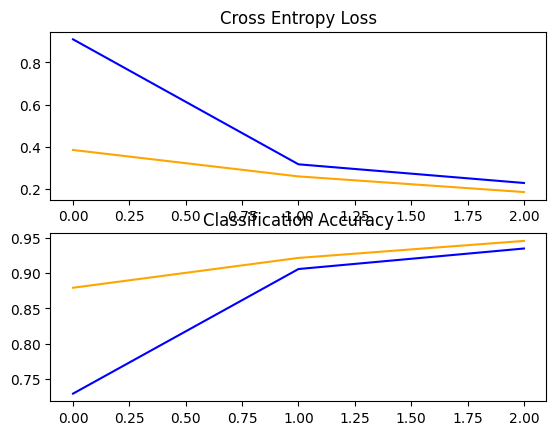

In [31]:
##############################
# B8. Plot the learning curves
##############################

# Load model weights
model = build_mnist_model().eval()
model.load_state_dict(torch.load('mnisft.pt'))
model = model.to(device)

# TODO B8.1. Evaluate model
with torch.no_grad():
    acc = metric(y_test, predict(model, X_test, 64).argmax(dim=-1).cpu())

print('> %.3f' % (acc * 100.0))

# TODO B8.2. Plot the learning curves
summarize_diagnostics(history)